# Aula 15 &mdash; Regressão Logística

Renato Vimieiro

rv2 {em} cin.ufpe.br

maio 2017

## Introdução

Nas aulas anteriores nos dedicamos ao estudo do problema de aprendizado supervisionado de predição de valores para uma variável alvo (dependente) a partir dos dados (variáveis independentes). Vimos que o modelo linear ajustado pelo método dos mínimos quadrados, apesar de ser uma simplificação bem drástica da realidade (que obviamente não é linear), fornecia bastante informações acerca dos dados como um todo, mas sobretudo da relação entre as variáveis. Embora o modelo fosse bastante útil, ele é restrito à predição de valores para variáveis quantitativas. Surge, então, a dúvida sobre a aplicação, ou melhor, o ajuste de modelos lineares para predição de variáveis categóricas. Esse problema é conhecido como **classificação**.

Para entendermos os conceitos relacionados ao problema, vamos usar um conjunto de dados real sobre câncer de próstata publicado em 1989. A referência do estudo é:

*Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989)
Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, Journal of Urology 141(5), 1076–1083*

Esse conjunto de dados é amplamente usado para o ensino de diversas técnicas. Frequentemente ele está nos pacotes de R e Python como exemplo. A ideia do estudo era avaliar a correlação entre o valor do PSA e outros dados clínicos de pacientes prestes a terem a próstata retirada (prostatectomia). O conjunto possui as seguintes variáveis:

- **lcavol** log do volume do câncer 
- **lweight** log do peso da próstata
- **age** idade do paciente
- **lbph** log da quantidade de tumor benigno
- **svi** variável indicadora se houve invasão da vesícula seminal 
- **lcp** log da penetração do tumor na cápsula prostática (tecido que contém a próstata)
- **gleason** escore de Gleason
- **pgg45** percentual de escores de Gleason 4 ou 5 (pgg45)
- **lpsa** log do valor do PSA

O escore de Gleason é uma métrica usada pelos patologistas para avaliar a gravidade e o prognóstico das amostras estudadas. Em geral, um escore de Gleason entre 5-6 indica que há grandes chances do câncer ser tratado e curado, ou seja está associado a um bom prognóstico, enquanto escores entre 8-10 indicam que o tumor já é ou vai se tornar bastante agressivo e há poucas chances do paciente ser curado (mau prognóstico). No caso do escore 7, o comportamento do tumor é mais heterogêneo, podendo o paciente ter bom ou mau prognóstico. No entanto, ele é mais associado a um mau prognóstico que a um bom.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import color_palette
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score

%matplotlib inline

In [2]:
prostate = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data",
                       header=0,index_col=0,sep='\t')
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


No estudo original, o objetivo era modelar o nível de PSA dos pacientes. Contudo, aqui vamos modificar o objetivo para predizer (classificar) se um paciente tem um bom ou mau prognóstico baseado em seus dados clínicos. Para isso vamos criar uma variável categórica *prognóstico* que terá os valores *bom* e *mau* baseados nos escores de Gleason dos pacientes.

In [3]:
prostate['prognostico'] = prostate.gleason.map(lambda x: x >=7 and 'mau' or 'bom')
prostate.prognostico.value_counts()

mau    62
bom    35
Name: prognostico, dtype: int64

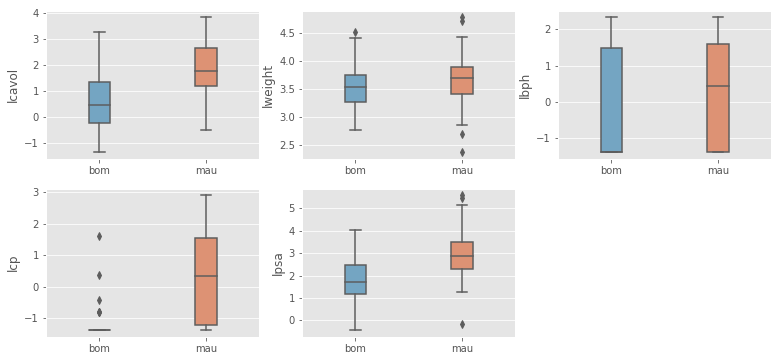

In [4]:
fig, axes = plt.subplots(2,3,figsize=(13,6))
sns.boxplot(x='prognostico',y='lcavol',data=prostate,ax=axes[0][0],width=.2,palette=color_palette(['#67a9cf','#ef8a62']))
sns.boxplot(x='prognostico',y='lweight',data=prostate,ax=axes[0][1],width=.2,palette=color_palette(['#67a9cf','#ef8a62']))
sns.boxplot(x='prognostico',y='lbph',data=prostate,ax=axes[0][2],width=.2,palette=color_palette(['#67a9cf','#ef8a62']))
sns.boxplot(x='prognostico',y='lcp',data=prostate,ax=axes[1][0],width=.2,palette=color_palette(['#67a9cf','#ef8a62']))
sns.boxplot(x='prognostico',y='lpsa',data=prostate,ax=axes[1][1],width=.2,palette=color_palette(['#67a9cf','#ef8a62']))
#sns.boxplot(x='prognostico',y=prostate.prognostico.value_counts(),data=prostate,ax=axes[1][2])
axes[0][0].xaxis.label.set_visible(False)
axes[0][1].xaxis.label.set_visible(False)
axes[0][2].xaxis.label.set_visible(False)
axes[1][0].xaxis.label.set_visible(False)
axes[1][1].xaxis.label.set_visible(False)
fig.delaxes(axes[1][2])

## Conjuntos de treinamento e teste

O objetivo de um algoritmo de classificação é ajustar um modelo aos dados de forma a predizer a classe de um objeto. A intenção é obter um modelo que seja geral o suficiente para classificar de forma acurada objetos que não tenham sido usados durante a fase de ajuste (treinamento). Dessa forma, frequentemente dividimos o conjunto de dados em duas partes: treinamento e teste. O primeiro é usado durante a fase de ajuste (treinamento) do modelo, equanto o segundo é usado para avaliar sua qualidade.

Se notarmos o conjunto de dados de câncer de próstata usado como exemplo, existe uma variável adicional *train*. Essa variável indica se o objeto será usado para o treinamento ou teste do modelo. Assim podemos dividir os dados em treinamento e teste a partir dessa variável.

In [5]:
treino = prostate[prostate.train=='T'].drop('train',axis=1)
print(treino.shape)
print(treino.prognostico.value_counts())
teste = prostate[prostate.train=='F'].drop('train',axis=1)
print(teste.shape)
print(teste.prognostico.value_counts())

(67, 10)
mau    42
bom    25
Name: prognostico, dtype: int64
(30, 10)
mau    20
bom    10
Name: prognostico, dtype: int64


O conjunto de dados original foi dividido em 1/3 teste e 2/3 treinamento (em geral, divide-se o conjunto em 70-30% entre treino e teste). Fortuitamente mantivemos a mesma proporção de objetos das classes bom e mau tanto nos dois conjuntos. Isso nem sempre ocorre. É bom o analista se atentar e refazer a amostragem caso seja de interesse preservar as características.

## Validação cruzada

Embora seja usado em muitas ocasiões, esse esquema de divisão entre treino e teste é bastante criticado por nem sempre fornecer uma boa avaliação do modelo. Isso é ainda mais crítico quando trabalhamos com poucos dados. Nesses casos, uma divisão enviesada dos conjuntos de treino e teste pode acarretar sobre-estimação ou subestimação da qualidade do modelo. Por exemplo, uma mudança drástica na distribuição das classes nos conjuntos de treino e teste pode levar a grandes erros de predição. Se houver preponderância de uma classe no conjunto de treinamento, o modelo tenderá a valorizar esta classe, ou seja se ajustará melhor a ela negligenciando as outras. Isso é natural uma vez que, ao se ajustar à classe dominante, o erro do modelo tende a cair. Contudo, quando a situação se inverter no conjunto de teste, as taxas de erro serão elevadas, refletindo o fato de que os dados não seguiram a mesma distribuição.

Uma alternativa mais recomendada nesses casos é o uso de validação cruzada (cross-validation). Na validação cruzada, o conjunto de dados é dividido em $k$ partições (folds). A cada rodada $k-1$ partições são usadas no treinamento e a partição restante usada no teste. A qualidade do modelo é avaliada como a média dos resultados obtidos em cada rodada. 

O valor mais usado para $k$ é 10 (10-fold cross-validation). Porém esse valor deve ser ajustado conforme a disponibilidade de dados. A partição dos dados pode ser estratificada (mantém-se a proporção das classes) ou não.

## Regressão logística

Voltando ao problema da classificação dos pacientes em bom ou mau prognóstico, nossa primeira ideia para resolvê-lo nesse momento seria transformá-lo num problema de regressão linear. Ou seja, poderíamos transformar a variável prognóstico numa variável fictícia como fizemos com as variáveis categóricas introduzidas no modelo. Logo, se o modelo desse um valor próximo de 1, atribuiríamos uma classe, caso contrário atribuiríamos a outra.

In [6]:
treinoCP = treino.copy()
treinoCP['Ip'] = treinoCP.prognostico.map(lambda x: x=='mau' and 1 or 0)
model = smf.ols("Ip ~ lpsa + lcavol + lweight",data=treinoCP).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ip   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     9.858
Date:                Thu, 03 May 2018   Prob (F-statistic):           2.03e-05
Time:                        10:32:04   Log-Likelihood:                -33.505
No. Observations:                  67   AIC:                             75.01
Df Residuals:                      63   BIC:                             83.83
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8802      0.400      2.199      0.032       0.080       1.680
lpsa           0.1479      0.068      2.190      0.032       0.013       0.283
lcavol         0.1184      0.060      1.967      0.054      -0.002       0.239
lweight       -0.2128      0.122     -1.743      0.086      -0.457       0.031
==============================================================================
Omnibus:                        3.213   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.736
Skew:                          -0.387   Prob(JB):                        0.255
Kurtosis:                       2.384   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

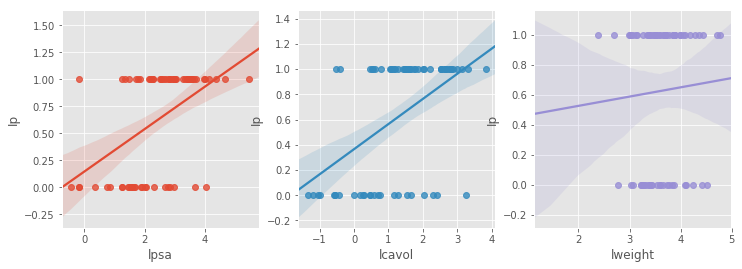

In [7]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
sns.regplot(x='lpsa',y='Ip',data=treinoCP,ax=axes[0])
sns.regplot(x='lcavol',y='Ip',data=treinoCP,ax=axes[1])
sns.regplot(x='lweight',y='Ip',data=treinoCP,ax=axes[2])

Vemos que, apesar do modelo com todas as variáveis indique relação entre elas e o prognóstico, os modelos individuais acima deixam bem claro que essa relação não foi exatamente modelada. O modelo linear não consegue se ajustar aos dados. É percepível que o domínio do modelo não é restrito ao domínio da variável prognóstico ${0,1}$. Outra questão a ser levada em conta é que o modelo também não pode ser generalizado para mais de duas categorias. Assim, usamos como alternativo a regressão logística.

No modelo logístico, ao invés de modelarmos o valor da variável dependente em função das variáveis independentes, modelamos a probabilidade condicional da variável dependente em função das variáveis independentes, $P(Y=1|x_1,x_2,\dots,x_p)$. Por exemplo, poderíamos modelar $P(prognóstico=mau|lpsa)$. Nesse caso, poderíamos dizer que o prognóstico do paciente é mau se $P(prognóstico=mau|lpsa) > 0.5$, ou se quisermos ser menos alarmantes, $P(prognóstico=mau|lpsa) > 0.8$. Por conveniência, expressamos $P(Y=1|X) = p(X)$.

Como discutimos, modelar $p(X) = \beta_0 + \beta_1X$ fornece um péssimo modelo. Na regressão logística, usamos a função logística como modelo:

\begin{equation*}
p(X) = \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}
\end{equation*}

Após algumas manipulações algébricas, podemos verificar que

\begin{equation*}
\frac{p(X)}{1-p(X)} = e^{\beta_0 + \beta_1X}
\end{equation*}

A proporção à esqueda é chamada de **chance**. Se tomarmos o logarítmo da chance (**logit**), temos o nosso modelo linear

\begin{equation*}
\log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X
\end{equation*}

O modelo é ajustado pela máxima verossímilhança ao invés do método dos mínimos quadrados. Queremos estimar os valores de $\beta_0$ e $\beta_1$ tais que, quando substituídos na definição de probabilidade condicional do nosso modelo, o valor seja o mais próximo possível da probabilidade real. A função de verossimilhança é

$$L(\beta_0,\beta_1) = \prod p(x_i)^{y_i}(1-p(x_i))^{1-y_i} = \prod_{i,y_i=1} p(x_i)\prod_{i^\prime,y_{i^\prime}=0} (1-p(x_{i^\prime}))$$

Para encontrar o valor máximo, derivamos a função com respeito aos coeficientes e igualamos a zero. Como a derivada de produtos é mais complexa que a de somas, usamos o log da função de verossimilhança.

$$\log(L(\beta_0,\beta_1)) = l(\beta_0,\beta_1) = \sum_{i,y_i=1} \log(p(x_i)) + \sum_{i^\prime,y_{i^\prime}=0} \log(1-p(x_{i^\prime}))$$

O modelo pode ser resolvido por qualquer método iterativo para o cálculo do zero de funções, por exemplo, o método de Newton-Raphson. Não vamos explorar as propriedades matemáticas do modelo, tampouco resolvê-lo. O importante em nosso caso é que existem ferramentas para fazê-lo em Python.

In [9]:
treinoCP = sm.add_constant(treino.copy())
treinoCP['Ip'] = treinoCP.prognostico.map(lambda x: x=='mau' and 1 or 0)
model = smf.logit("Ip ~ lpsa",treinoCP).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.527651
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     Ip   No. Observations:                   67
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 May 2018   Pseudo R-squ.:                  0.2013
Time:                        10:32:26   Log-Likelihood:                -35.353
converged:                       True   LL-Null:                       -44.260
                                        LLR p-value:                 2.434e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9992      0.760     -2.631      0.009      -3.489      -0.510
lpsa           1.0833      0.311      3.484      0.000       0.474       1.693
==============================================================================
"""

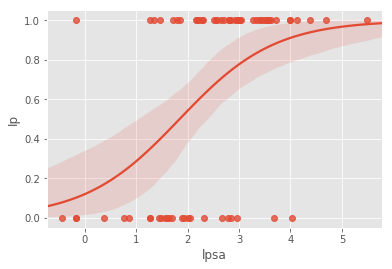

In [11]:
sns.regplot(x='lpsa',y='Ip',logistic=True,data=treinoCP);

In [12]:
model = smf.logit("Ip ~ lpsa + lcavol + lweight + lcp + lbph",treinoCP,).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.423807
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     Ip   No. Observations:                   67
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 May 2018   Pseudo R-squ.:                  0.3585
Time:                        10:32:59   Log-Likelihood:                -28.395
converged:                       True   LL-Null:                       -44.260
                                        LLR p-value:                 6.717e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5834      2.935      1.562      0.118      -1.169      10.336
lpsa           1.0838      0.539      2.011      0.044       0.027       2.140
lcavol         0.0818      0.433      0.189      0.850      -0.767       0.930
lweight       -1.6921      0.890     -1.901      0.057      -3.437       0.053
lcp            0.9065      0.412      2.198      0.028       0.098       1.715
lbph           0.2431      0.265      0.917      0.359      -0.276       0.762
==============================================================================
"""

Agora observamos que o modelo se ajustou melhor aos dados. Da mesma forma que nos modelos de regressão linear simples e múltipla, os p-values estão relacionados com a hipótese nula de que os coeficientes não estão relacionados à variável dependente. Por outro lado, a interpretação dos coeficientes não é tão direta. Podemos interpretá-los como: valores positivos indicam que o aumento de $X$ multiplica a chance por $e^{\beta_1}$ unidades, enquanto valores negativos a dividem.

## Predizendo os valores do conjunto de teste

Uma vez que obtivemos o modelo, agora podemos fazer previsões para o conjunto de teste e avaliar sua precisão.

In [13]:
model.predict(teste)

7     0.180741
9     0.126993
10    0.206372
15    0.412494
22    0.900738
25    0.358521
26    0.536305
28    0.302081
32    0.376385
34    0.413963
36    0.321005
42    0.349197
44    0.751478
48    0.659462
49    0.505584
50    0.743541
53    0.857350
54    0.919921
55    0.557184
57    0.950451
62    0.975161
64    0.974580
65    0.538045
66    0.781062
73    0.800235
74    0.977351
80    0.895569
84    0.982613
95    0.998565
97    0.999024
dtype: float64

Como podemos ver, o modelo retorna as probabilidades associadas a cada objeto no conjunto de teste de terem um mau prognóstico. Podemos converter tais probabilidades em classes. Podemos arbitrariamente dizer que se a probabilidade for maior que 0.5 então a classe é mau, e bom caso contrário.

In [14]:
model.predict(teste).map(lambda x: x > 0.5 and 'mau' or 'bom')

7     bom
9     bom
10    bom
15    bom
22    mau
25    bom
26    mau
28    bom
32    bom
34    bom
36    bom
42    bom
44    mau
48    mau
49    mau
50    mau
53    mau
54    mau
55    mau
57    mau
62    mau
64    mau
65    mau
66    mau
73    mau
74    mau
80    mau
84    mau
95    mau
97    mau
dtype: object

Podemos agora comparar tais valores com os valores originais para avaliarmos a precisão do modelo

In [20]:
df = pd.DataFrame(dict(prob=model.predict(teste),
                  pred=model.predict(teste).map(lambda x: x > 0.5 and 'mau' or 'bom'),
                  real=teste.prognostico))

In [22]:
df['gleason'] = teste.gleason
df

,pred,prob,real,gleason
7,bom,0.180741,bom,6
9,bom,0.126993,bom,6
10,bom,0.206372,bom,6
15,bom,0.412494,mau,7
22,mau,0.900738,mau,7
25,bom,0.358521,bom,6
26,mau,0.536305,bom,6
28,bom,0.302081,mau,7
32,bom,0.376385,bom,6
34,bom,0.413963,bom,6


Podemos ainda sumarizar os resultados numa tabela, mostrando os acertos e erros do modelo.

In [19]:
pd.crosstab(df.pred,df.real)

real,bom,mau
pred,,
bom,6,4
mau,4,16


Essa tabela é conhecida como **tabela de contingência**. A diagonal principal mostra os acertos do modelo, enquanto a secundária mostra os erros. Os exemplos que eram realmente maus e foram classificados como tal são chamados de *verdadeiros positivos* (TP), já os bons classificados corretamente são chamados de *verdadeiros negativos* (TN). Os bons classificados de maus são chamados de *falsos positivos* (FP) e os maus classificados de bons são *falsos negativos*.

A **acurácia** do modelo é a proporção de acertos que o modelo teve. Além dessa métrica, outras duas métricas de qualidade são **sensitividade** e **especificidade** que revelam a capacidade do modelo de classificar corretamente os exemplos que eram positivos (maus) e os que eram negativos (bons).

\begin{align}
ACC & = \frac{TP+TN}{TP+TN+FP+FN}\\
SEN & = \frac{TP}{TP+FN}\\
ESP & = \frac{TN}{TN+FP}\\
\end{align}

Dessa forma, podemos avaliar a qualidade do nosso modelo.

In [16]:
tabcont = pd.crosstab(df.pred,df.real).values
acc = np.sum(tabcont.diagonal())/teste.shape[0]
sen = tabcont[1,1]/(tabcont[1,1]+tabcont[0,1])
esp = tabcont[0,0]/(tabcont[0,0]+tabcont[1,0])

print("acc= {:.3f}, sen={:.3f}, esp={:.3f}".format(acc,sen,esp))

acc= 0.733, sen=0.800, esp=0.600


Assim observamos que nosso modelo acertou 73% das classificações, sendo mais preciso com exemplos positivos (mau prognóstico), acertando 80%, que com exemplos negativos (bom prognóstico), acertando 60%. 